# Train Stacking

Best F1 score BERT model on HS_C dataset are used

In [1]:
# This automates data tabulation onto google sheets 

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis'

# Change the current working directory
os.chdir(new_directory)

# Use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('thesis-432315-12daec8d1ff6.json', scope)

service = build('sheets', 'v4', credentials=creds)

client = gspread.authorize(creds)

spreadsheet_id = '1ReMgKOtkETAbtnnqkJy0eo4M2QfIq9fxtV-5ysZSdJ8' 

## Load Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis/Development'

# Change the current working directory
os.chdir(new_directory)

# Adjust file paths to local system
file_path = 'Corpus/data_b.csv'
df = pd.read_csv(file_path)

# Split the data
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Load Models and Tokenizers

In [3]:
def load_model_and_tokenizer(model_path, tokenizer_path, base_model):
    # Load the tokenizer from the local directory
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Load the configuration from the base model, then update configuration if needed
    config = AutoConfig.from_pretrained(base_model, num_labels=2)

    # Initialize the model with the configuration
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

    # Ensure the model is in evaluation mode
    model.eval()
    
    return model, tokenizer

model_info = {
    
    'BERT cased': {
        'model_path': 'BERT models/hs_bert-base-cased-finetuned',
        'tokenizer_path': 'BERT models/hs_bert-base-cased-finetuned',
        'base_model': 'google-bert/bert-base-cased'
    },

    'DistilBERT uncased': {
        'model_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'tokenizer_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'base_model': 'distilbert/distilbert-base-uncased'
    },

    'DeBERTa': {
        'model_path': 'BERT models/hs_DeBERTa-finetuned',
        'tokenizer_path': 'BERT models/hs_DeBERTa-finetuned',
        'base_model': 'microsoft/deberta-v3-base'
    },
    
    'BERT uncased': {
        'model_path': 'BERT models/hs_bert-base-uncased-finetuned',
        'tokenizer_path': 'BERT models/hs_bert-base-uncased-finetuned',
        'base_model': 'google-bert/bert-base-uncased'
    },

}


models_and_tokenizers = {name: load_model_and_tokenizer(info['model_path'], 
                                                        info['tokenizer_path'], 
                                                        info['base_model']) 
                         for name, info in model_info.items()}

## Apply Tokenization

In [4]:
def texts_to_dataloader(texts, tokenizer, batch_size=32):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

## Perform Stacking

In [5]:
%load_ext memory_profiler

In [6]:
%%memit

def get_meta_features(model, tokenizer, df, device):
    model.to(device)
    model.eval()
    print(f"Generating meta-features for model")
    dataloader = texts_to_dataloader(df['text'].tolist(), tokenizer, batch_size=32)
    meta_features = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            meta_features.append(probs.cpu().numpy())
    print(f"Meta-features generated")
    return np.concatenate(meta_features)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Cross-validation setup
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
train_meta_features_list = []
test_meta_features_list = []

# Generate meta-features for each fold
for train_index, val_index in skf.split(train_df['text'], train_df['label']):
    X_train_fold, X_val_fold = train_df.iloc[train_index], train_df.iloc[val_index]
    y_train_fold, y_val_fold = train_df['label'].iloc[train_index], train_df['label'].iloc[val_index]
    print(f"Processing fold: train_index={train_index}, val_index={val_index}")

    fold_meta_features_list = []
    for name, (model, tokenizer) in models_and_tokenizers.items():
        print(f"Using model: {name} for validation fold")
        fold_meta_features = get_meta_features(model, tokenizer, X_val_fold, device)
        fold_meta_features_list.append(fold_meta_features)
    
    train_meta_features_list.append(np.hstack(fold_meta_features_list))
    print("Stacked fold meta-features")

# Generate meta-features from the test set by training on the entire training set
for name, (model, tokenizer) in models_and_tokenizers.items():
    print(f"Generating test meta-features using model: {name}")
    test_meta_features = get_meta_features(model, tokenizer, test_df, device)
    test_meta_features_list.append(test_meta_features)

# Stack meta-features horizontally
train_meta_features = np.vstack(train_meta_features_list)
test_meta_features = np.hstack(test_meta_features_list)
print("Final train meta-features shape:", train_meta_features.shape)
print("Final test meta-features shape:", test_meta_features.shape)

Processing fold: train_index=[   0    1    2 ... 5812 5813 5815], val_index=[   3    4    5 ... 5800 5802 5814]
Using model: BERT cased for validation fold
Generating meta-features for model
Meta-features generated
Using model: DistilBERT uncased for validation fold
Generating meta-features for model
Meta-features generated
Using model: DeBERTa for validation fold
Generating meta-features for model
Meta-features generated
Using model: BERT uncased for validation fold
Generating meta-features for model
Meta-features generated
Stacked fold meta-features
Processing fold: train_index=[   0    2    3 ... 5812 5813 5814], val_index=[   1    6   24 ... 5810 5811 5815]
Using model: BERT cased for validation fold
Generating meta-features for model
Meta-features generated
Using model: DistilBERT uncased for validation fold
Generating meta-features for model
Meta-features generated
Using model: DeBERTa for validation fold
Generating meta-features for model
Meta-features generated
Using model: BER

### Train LR

In [7]:
%memit
# Train the LR meta-classifier
lr_meta_classifier = LogisticRegression()
lr_meta_classifier.fit(train_meta_features, train_df['label'].values)

lr_final_predictions = lr_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2660.41 MiB, increment: 0.02 MiB


### Train NB

In [8]:
%memit
# Train the NB meta-classifier
nb_meta_classifier = GaussianNB()
nb_meta_classifier.fit(train_meta_features, train_df['label'].values)

nb_final_predictions = nb_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2661.36 MiB, increment: -0.20 MiB


### Train DT

In [9]:
%memit
# Train the DT meta-classifier
dt_meta_classifier = DecisionTreeClassifier(max_depth=None)  
dt_meta_classifier.fit(train_meta_features, train_df['label'].values)

dt_final_predictions = dt_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2661.34 MiB, increment: -0.02 MiB


### Train SVM

In [10]:
%memit
# Train the SVM meta-classifier
svm_meta_classifier = SVC(kernel='linear', probability=True)
svm_meta_classifier.fit(train_meta_features, train_df['label'].values)

svm_final_predictions = svm_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2661.80 MiB, increment: 0.00 MiB


## Evaluate Models

### LR

In [11]:
# Evaluate
precision = precision_score(test_df['label'].values, lr_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, lr_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, lr_final_predictions)
f1 = f1_score(test_df['label'].values, lr_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, lr_final_predictions)

print("Logistic Regression")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Logistic Regression
Precision: 0.3448275862068966
Recall: 0.017497812773403325
Ensemble accuracy: 0.5342960288808665
F1 Score: 0.03330557868442964
Confusion Matrix:
[[1312   38]
 [1123   20]]


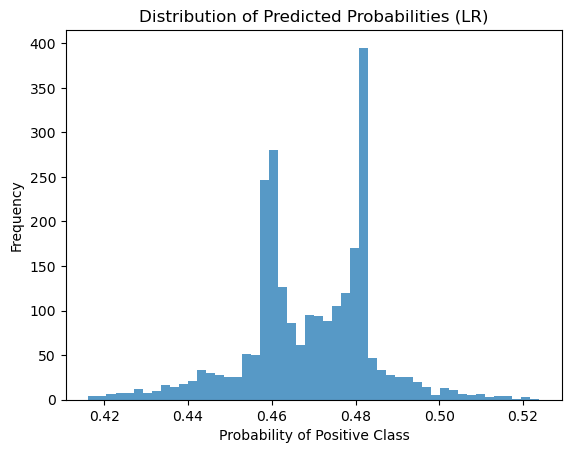

In [12]:
# Get probability scores for the positive class
lr_prob_scores = lr_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], lr_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (lr_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Logistic Regression")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

lr_thresh = best_thresh

Adjusted threshold: 0.01
Optimized Logistic Regression
Precision: 0.4584837545126354
Recall: 1.0
Accuracy: 0.4584837545126354
F1 Score: 0.6287128712871287
Confusion Matrix:
[[   0 1350]
 [   0 1143]]


In [14]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B4:E4'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### NB

In [15]:
# Evaluate
precision = precision_score(test_df['label'].values, nb_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, nb_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, nb_final_predictions)
f1 = f1_score(test_df['label'].values, nb_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, nb_final_predictions)

print("Naive Bayes")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Naive Bayes
Precision: 0.09641255605381166
Recall: 0.0752405949256343
Ensemble accuracy: 0.2527075812274368
F1 Score: 0.08452088452088452
Confusion Matrix:
[[ 544  806]
 [1057   86]]


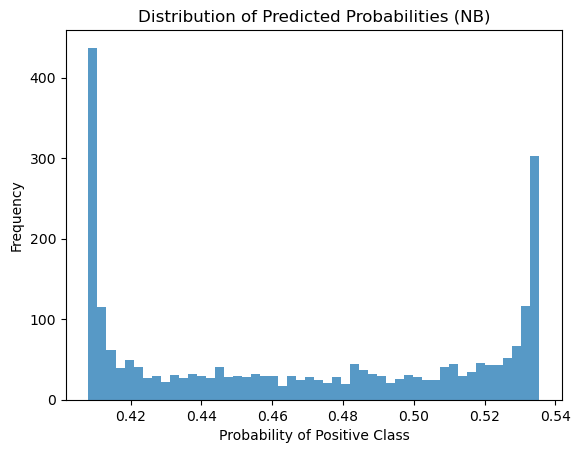

In [16]:
# Get probability scores for the positive class
nb_prob_scores = nb_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(nb_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (NB)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [17]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], nb_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (nb_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Naive Bayes")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

nb_thresh = best_thresh

Adjusted threshold: 0.01
Optimized Naive Bayes
Precision: 0.4584837545126354
Recall: 1.0
Accuracy: 0.4584837545126354
F1 Score: 0.6287128712871287
Confusion Matrix:
[[   0 1350]
 [   0 1143]]


In [18]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B5:E5'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### DT

In [19]:
# Evaluate
precision = precision_score(test_df['label'].values, dt_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, dt_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, dt_final_predictions)
f1 = f1_score(test_df['label'].values, dt_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, dt_final_predictions)

print("Decision Tree")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Decision Tree
Precision: 0.4556213017751479
Recall: 0.4715660542432196
Ensemble accuracy: 0.4993983152827918
F1 Score: 0.46345657781599314
Confusion Matrix:
[[706 644]
 [604 539]]


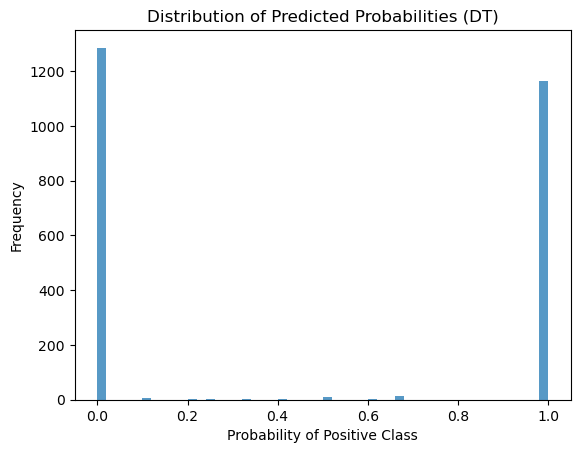

In [20]:
# Get probability scores for the positive class
dt_prob_scores = dt_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(dt_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (DT)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], dt_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (dt_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Decision Tree")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

dt_thresh = best_thresh

Adjusted threshold: 0.01
Optimized Decision Tree
Precision: 0.45816072908036454
Recall: 0.48381452318460194
Accuracy: 0.5010028078620137
F1 Score: 0.4706382978723404
Confusion Matrix:
[[696 654]
 [590 553]]


In [22]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B6:E6'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### SVM

In [23]:
# Evaluate
precision = precision_score(test_df['label'].values, svm_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, svm_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, svm_final_predictions)
f1 = f1_score(test_df['label'].values, svm_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, svm_final_predictions)

print("SVM")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

SVM
Precision: 0.0
Recall: 0.0
Ensemble accuracy: 0.5415162454873647
F1 Score: 0.0
Confusion Matrix:
[[1350    0]
 [1143    0]]


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


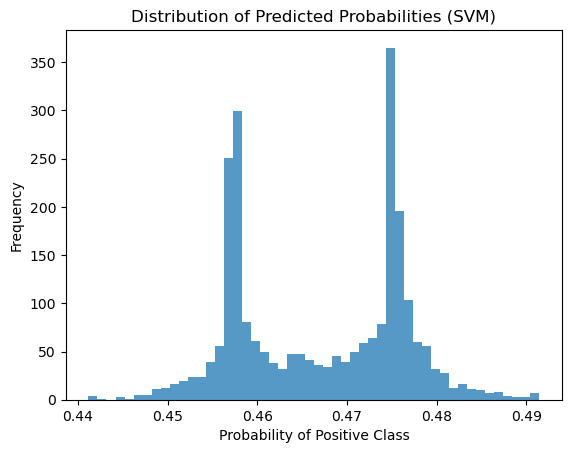

In [24]:
# Get probability scores for the positive class
svm_prob_scores = svm_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(svm_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], svm_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (svm_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized SVM")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

svm_thresh = best_thresh

Adjusted threshold: 0.01
Optimized SVM
Precision: 0.4584837545126354
Recall: 1.0
Accuracy: 0.4584837545126354
F1 Score: 0.6287128712871287
Confusion Matrix:
[[   0 1350]
 [   0 1143]]


In [26]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B7:E7'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


# Validate on Data C

## Load Data C Dataset

In [27]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load validation data
validation_file_path = 'Corpus/data_c.csv'
validation_df = pd.read_csv(validation_file_path)

## Perform Stacking

In [28]:
%memit

# Generate meta-features for validation set
validation_meta_features = [get_meta_features(model, tokenizer, validation_df, device) 
                            for model, tokenizer in models_and_tokenizers.values()]

# Stack meta-features
validation_meta_features = np.hstack(validation_meta_features)

# Predict with LR meta-classifier
lr_validation_predictions = lr_meta_classifier.predict(validation_meta_features)

# Predict with NB meta-classifier
nb_validation_predictions = nb_meta_classifier.predict(validation_meta_features)

# Predict with DT meta-classifier
dt_validation_predictions = dt_meta_classifier.predict(validation_meta_features)

# Predict with SVM meta-classifier
svm_validation_predictions = svm_meta_classifier.predict(validation_meta_features)

# Extract true labels from the validation set
true_labels = validation_df['label'].values

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2790.48 MiB, increment: -0.20 MiB
Generating meta-features for model
Meta-features generated
Generating meta-features for model
Meta-features generated
Generating meta-features for model
Meta-features generated
Generating meta-features for model
Meta-features generated


## Validate Models

### LR

In [29]:
# Calculate metrics
accuracy = accuracy_score(true_labels, lr_validation_predictions)
precision = precision_score(true_labels, lr_validation_predictions, average='binary')
recall = recall_score(true_labels, lr_validation_predictions, average='binary')
f1 = f1_score(true_labels, lr_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, lr_validation_predictions)

# Print the metrics
print("Logistic Regression")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)

Logistic Regression
Accuracy: 0.5295073091499729
Precision: 0.3902439024390244
Recall: 0.018604651162790697
F1 Score: 0.03551609322974473
Confusion Matrix:
 [[962  25]
 [844  16]]


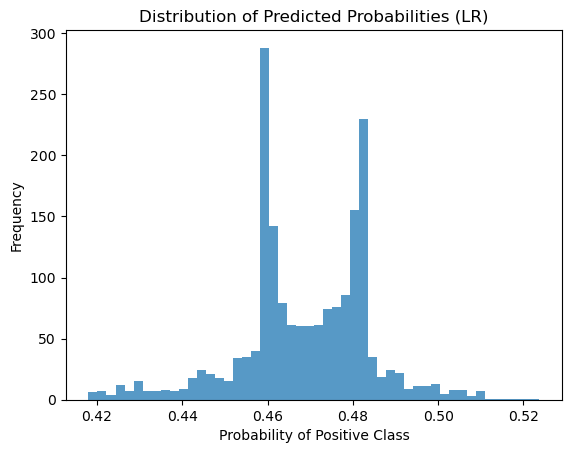

In [30]:
# Get probability scores for the positive class
lr_prob_scores = lr_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized LR

In [31]:
# Apply the new threshold
adjusted_predictions = (lr_prob_scores >= lr_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(validation_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(validation_df['label'], adjusted_predictions)

print("Optimized Logistic Regression")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Logistic Regression
Precision: 0.4656199242014077
Recall: 1.0
Accuracy: 0.4656199242014077
F1 Score: 0.6353897303287772
Confusion Matrix:
[[  0 987]
 [  0 860]]


In [32]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F4:I4'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [33]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Hate Speech', 'Non Hatespeech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='4 Stacking-1 LR'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [34]:

# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, '4STK-1 LR.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/4STK-1 LR.png


### NB

In [35]:
# Calculate metrics
accuracy = accuracy_score(true_labels, nb_validation_predictions)
precision = precision_score(true_labels, nb_validation_predictions, average='binary')
recall = recall_score(true_labels, nb_validation_predictions, average='binary')
f1 = f1_score(true_labels, nb_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, nb_validation_predictions)

# Print the metrics
print("Naive Bayes")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)

Naive Bayes
Accuracy: 0.24959393611261504
Precision: 0.09161490683229814
Recall: 0.0686046511627907
F1 Score: 0.07845744680851063
Confusion Matrix:
 [[402 585]
 [801  59]]


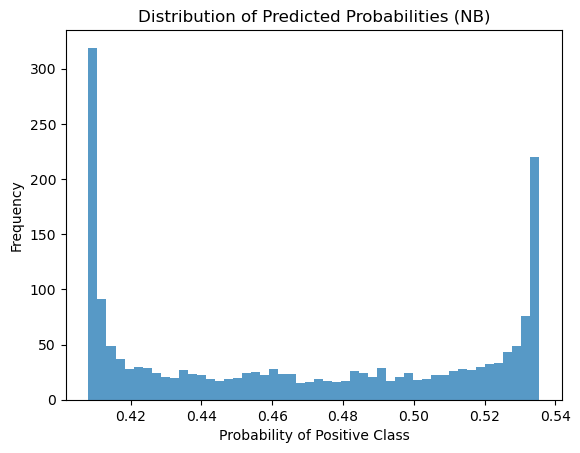

In [36]:
# Get probability scores for the positive class
nb_prob_scores = nb_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(nb_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (NB)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized NB

In [37]:
# Apply the new threshold
adjusted_predictions = (nb_prob_scores >= nb_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(validation_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(validation_df['label'], adjusted_predictions)

print("Optimized Naive Bayes")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Naive Bayes
Precision: 0.4656199242014077
Recall: 1.0
Accuracy: 0.4656199242014077
F1 Score: 0.6353897303287772
Confusion Matrix:
[[  0 987]
 [  0 860]]


In [38]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F5:I5'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [39]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Hate Speech', 'Non Hatespeech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='4 Stacking-1 NB'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [40]:

# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, '4STK-1 NB.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/4STK-1 NB.png


### DT

In [41]:
# Calculate metrics
accuracy = accuracy_score(true_labels, dt_validation_predictions)
precision = precision_score(true_labels, dt_validation_predictions, average='binary')
recall = recall_score(true_labels, dt_validation_predictions, average='binary')
f1 = f1_score(true_labels, dt_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, dt_validation_predictions)

# Print the metrics
print("Decision Tree")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)

Decision Tree
Accuracy: 0.5154304277206281
Precision: 0.48
Recall: 0.4883720930232558
F1 Score: 0.484149855907781
Confusion Matrix:
 [[532 455]
 [440 420]]


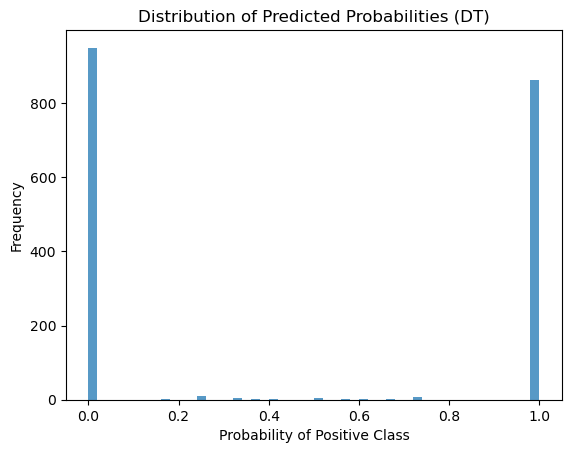

In [42]:
# Get probability scores for the positive class
dt_prob_scores = dt_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(dt_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (DT)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized DT

In [43]:
# Apply the new threshold
adjusted_predictions = (dt_prob_scores >= dt_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(validation_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(validation_df['label'], adjusted_predictions)

print("Optimized Decision Tree")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Decision Tree
Precision: 0.4732739420935412
Recall: 0.4941860465116279
Accuracy: 0.5083919870059556
F1 Score: 0.48350398179749715
Confusion Matrix:
[[514 473]
 [435 425]]


In [44]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F6:I6'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [45]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Hate Speech', 'Non Hatespeech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='4 Stacking-1 DT'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [46]:

# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, '4STK-1 DT.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/4STK-1 DT.png


### SVM

In [47]:
# Calculate metrics
accuracy = accuracy_score(true_labels, svm_validation_predictions)
precision = precision_score(true_labels, svm_validation_predictions, average='binary')
recall = recall_score(true_labels, svm_validation_predictions, average='binary')
f1 = f1_score(true_labels, svm_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, svm_validation_predictions)

# Print the metrics
print("SVM")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)

SVM
Accuracy: 0.5343800757985923
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[987   0]
 [860   0]]


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


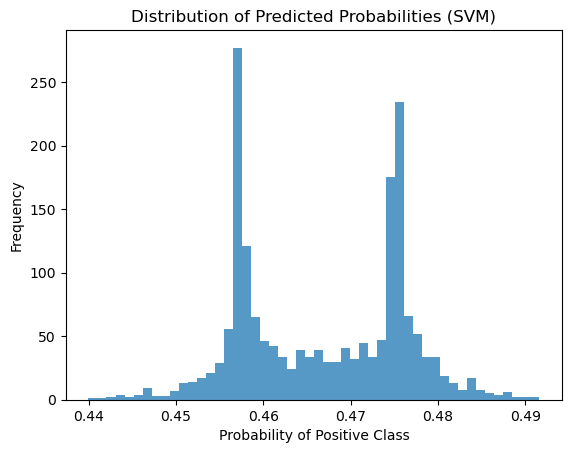

In [48]:
# Get probability scores for the positive class
svm_prob_scores = svm_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(svm_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized SVM

In [49]:
# Apply the new threshold
adjusted_predictions = (svm_prob_scores >= svm_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(validation_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(validation_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(validation_df['label'], adjusted_predictions)

print("Optimized SVM")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized SVM
Precision: 0.4656199242014077
Recall: 1.0
Accuracy: 0.4656199242014077
F1 Score: 0.6353897303287772
Confusion Matrix:
[[  0 987]
 [  0 860]]


In [50]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F7:I7'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [51]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Hate Speech', 'Non Hatespeech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='4 Stacking-1 SVM'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [52]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, '4STK-1 SVM.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS_Finetuned Models/Stacking/4STK-1 SVM.png
